## Insert Necessary Functions

In [1]:
# Imports and Functions
import argparse
import os
import time
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

    

import torchvision
import torchvision.transforms as transforms

from models import *   # bring everything in the folder models



def train(trainloader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()   ## at the begining of each epoch, this should be reset
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    model.train()

    end = time.time()  # measure current time
    
    for i, (input, target) in enumerate(trainloader):
        # measure data loading time
        data_time.update(time.time() - end)  # data loading time

        input, target = input.cuda(), target.cuda()

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss
        prec = accuracy(output, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec.item(), input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end) # time spent to process one batch
        end = time.time()


        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec {top1.val:.3f}% ({top1.avg:.3f}%)'.format(
                   epoch, i, len(trainloader), batch_time=batch_time,
                   data_time=data_time, loss=losses, top1=top1))

            

def validate(val_loader, model, criterion ):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
         
            input, target = input.cuda(), target.cuda()

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss
            prec = accuracy(output, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:  # This line shows how frequently print out the status. e.g., i%5 => every 5 batch, prints out
                print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec {top1.val:.3f}% ({top1.avg:.3f}%)'.format(
                   i, len(val_loader), batch_time=batch_time, loss=losses,
                   top1=top1))

    print(' * Prec {top1.avg:.3f}% '.format(top1=top1))
    return top1.avg


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n    ## n is impact factor
        self.count += n
        self.avg = self.sum / self.count

        
def save_checkpoint(state, is_best, fdir):
    filepath = os.path.join(fdir, 'checkpoint.pth')
    torch.save(state, filepath)
    if is_best:
        shutil.copyfile(filepath, os.path.join(fdir, 'model_best.pth.tar'))


def adjust_learning_rate(optimizer, epoch):
    """For resnet, the lr starts from 0.1, and is divided by 10 at 80 and 120 epochs"""
    adjust_list = [150, 225]
    if epoch in adjust_list:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * 0.1        

#model = nn.DataParallel(model).cuda()
#all_params = checkpoint['state_dict']
#model.load_state_dict(all_params, strict=False)
#criterion = nn.CrossEntropyLoss().cuda()
#validate(testloader, model, criterion)

In [2]:
import argparse
import os
import time
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
   

import torchvision
import torchvision.transforms as transforms

from models import *



def act_quantization(b):

    def uniform_quant(x, b=3):
        xdiv = x.mul(2 ** b - 1)
        xhard = xdiv.round().div(2 ** b - 1)
        return xhard

    class uq(torch.autograd.Function):   # here single underscore means this class is for internal use

        def forward(ctx, input, alpha):
            input_d = input/alpha
            input_c = input_d.clamp(max=1)  # Mingu edited for Alexnet
            input_q = uniform_quant(input_c, b)
            ctx.save_for_backward(input, input_q)
            input_q_out = input_q.mul(alpha)
            return input_q_out

    return uq().apply




def weight_quantization(b):

    def uniform_quant(x, b):
        xdiv = x.mul((2 ** b - 1))
        xhard = xdiv.round().div(2 ** b - 1)  
        return xhard

    class uq(torch.autograd.Function):

        def forward(ctx, input, alpha):
            input_d = input/alpha                          # weights are first divided by alpha                       
            input_c = input_d.clamp(min=-1, max=1)       # then clipped to [-1,1]
            sign = input_c.sign()
            input_abs = input_c.abs()
            input_q = uniform_quant(input_abs, b).mul(sign)
            ctx.save_for_backward(input, input_q)
            input_q_out = input_q.mul(alpha)               # rescale to the original range
            return input_q_out

    return uq().apply



class weight_quantize_fn(nn.Module):
    def __init__(self, w_bit):
        super(weight_quantize_fn, self).__init__()
        self.w_bit = w_bit-1
        self.weight_q = weight_quantization(b=self.w_bit)
        self.wgt_alpha = 0.0

    def forward(self, weight):
        weight_q = self.weight_q(weight, self.wgt_alpha)
        
        return weight_q
    
    

## Resnet-20 Model

In [3]:
# ResNet20
import argparse
import os
import time
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms

from models import *  # Import the ResNet20 and VGGNet16 models

global best_prec
use_gpu = torch.cuda.is_available()
print('=> Building model...')

batch_size = 160

model_name = "RESNET"
model = resnet20_cifar()

normalize = transforms.Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.262])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ]))
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ]))
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print_freq = 100

=> Building model...
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Training loop
lr = 2.2e-2
weight_decay = 9e-5
epochs = 180
best_prec = 0

model = model.cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)

if not os.path.exists('result'):
    os.makedirs('result')

fdir = 'result/' + str(model_name)

if not os.path.exists(fdir):
    os.makedirs(fdir)

for epoch in range(0, epochs):
    adjust_learning_rate(optimizer, epoch)
    train(trainloader, model, criterion, optimizer, epoch)
    
    print("Validation starts")
    prec = validate(testloader, model, criterion)

    is_best = prec > best_prec
    best_prec = max(prec, best_prec)
    print('best acc: {:.2f}%'.format(best_prec))
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_prec': best_prec,
        'optimizer': optimizer.state_dict(),
    }, is_best, fdir)

### Resnet-20 Quantization

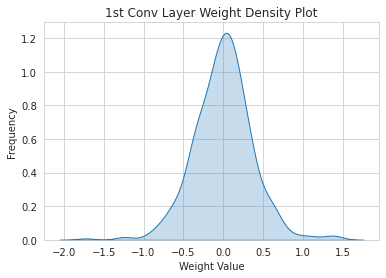

std 0.37045506


In [4]:
# Plot the density of weights; then find std, and then find alpha
import matplotlib.pyplot as plt
import seaborn as sns

model_name = "RESNET"
model = resnet20_cifar()

fdir = 'result/' + str(model_name) + '/model_best.pth.tar'
checkpoint = torch.load(fdir)
model.load_state_dict(checkpoint['state_dict'])

#----------------------
# Density plot of first conv layer's weights (find std and use 3*std)
first_conv_layer = model.conv1  
weights = first_conv_layer.weight.data.cpu().numpy() 
std = np.std(weights)
flatten = weights.reshape(-1)
sns.set_style('whitegrid')
sns.kdeplot(flatten, shade=True)
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.title('1st Conv Layer Weight Density Plot')
plt.show()
print("std", std)

In [5]:
# 4 bit; Quantizing the best model found during training
model_name = "RESNET"
model = resnet20_cifar()

fdir = 'result/' + str(model_name) + '/model_best.pth.tar'
checkpoint = torch.load(fdir)
model.load_state_dict(checkpoint['state_dict'])

#--------------------------
ALPHA = 3*std 

def weight_quantization_4bit(weight, alpha=ALPHA):
    return weight_quantization(b=4)(weight, alpha)


# 4 bit
for layer in model.modules():
    if isinstance(layer, torch.nn.Conv2d): #21 conv layers
        #print(layer)
        
        original_weights = layer.weight.data 
        w_quant = weight_quantization_4bit(original_weights)  
        layer.weight.data = w_quant  # Update

        #print("Quantized weights for this layer (4 bit):")
        #print(w_quant)

#torch.save(model.state_dict(), 'resnet20_4bit_quantized.pth')

    
    
    
#---------------------------------------
# Evaluate after Quantization
criterion = nn.CrossEntropyLoss().cuda()

model.eval()
model.cuda()

prec = validate(testloader, model, criterion)

Test: [0/63]	Time 1.381 (1.381)	Loss 0.7989 (0.7989)	Prec 84.375% (84.375%)
 * Prec 83.990% 


In [6]:
# 8 bit; Quantizing the best model found during training
model_name = "RESNET"
model = resnet20_cifar()

fdir = 'result/' + str(model_name) + '/model_best.pth.tar'
checkpoint = torch.load(fdir)
model.load_state_dict(checkpoint['state_dict'])


def weight_quantization_8bit(weight, alpha=ALPHA):
    return weight_quantization(b=8)(weight, alpha)


# 8 bit
for layer in model.modules():
    if isinstance(layer, torch.nn.Conv2d): #21 conv layers
        #print(layer)
        
        original_weights = layer.weight.data 
        w_quant = weight_quantization_8bit(original_weights)  
        layer.weight.data = w_quant  # Update

        #print("Quantized weights for this layer (4 bit):")
        #print(w_quant)

#torch.save(model.state_dict(), 'resnet20_8bit_quantized.pth')
      
    
    
    
#---------------------------------------
# Evaluate after Quantization
criterion = nn.CrossEntropyLoss().cuda()

model.eval()
model.cuda()

prec = validate(testloader, model, criterion)

Test: [0/63]	Time 0.170 (0.170)	Loss 0.3506 (0.3506)	Prec 93.125% (93.125%)
 * Prec 90.260% 


##### Observation

My observation is that when we use 4-bit quantization, the accuracy is lower than using 8-bit quantization. This makes sense because the weights of the convolution layer can be split into more bins using 8-bit quantization. If we use 4-bit system, we can only have 15 bins (2^4 - 1), which is much lower resolution than using 8-bit system which can give us 255 (2^8 -1) bins.